In [86]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)

from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 

import pandas as pd 
import math as m
import os, glob

In [87]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
ID = "01"
MODEL_NAME = "LSTM"
NUM_FEATURES = "12"
TARGET_NAME = "Volume"
MSE_RESULT = 0

In [89]:
RANGE = 3

HYPER_L1_IN = RANGE
EPOCHS = 10
BATCH_SIZE = 1

TEST_SIZE = .20
VAL_SIZE = .1

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [90]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

DF_EURUSD_ASK_1H_PROC.csv
EURUSD_ASK_1H_14F.csv


In [91]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2018-01-01 22:00:00,1.20143,1.20173,1.20062,1.20158,1623.5100,Monday,0,0.000000,0.000000,0.00000,0.0,0.0,0.0
1,2018-01-01 23:00:00,1.20158,1.20161,1.20044,1.20110,6297.2402,Monday,0,-0.000399,-0.000399,0.00000,0.0,0.0,0.0
2,2018-01-02 00:00:00,1.20109,1.20178,1.20096,1.20162,3564.4600,Tuesday,1,0.000433,0.000832,0.00000,0.0,0.0,0.0
3,2018-01-02 01:00:00,1.20162,1.20232,1.20141,1.20159,6219.6899,Tuesday,1,-0.000025,-0.000458,0.00000,0.0,0.0,0.0
4,2018-01-02 02:00:00,1.20157,1.20165,1.20081,1.20096,5386.5098,Tuesday,1,-0.000524,-0.000499,1.20137,0.0,0.0,0.0


In [92]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (15023, 14)
               Open          High           Low         Close         Volume  \
count  15023.000000  15023.000000  15023.000000  15023.000000   15023.000000   
mean       1.141308      1.141974      1.140634      1.141303   10819.459016   
std        0.043208      0.043281      0.043139      0.043206    8543.286582   
min        1.065520      1.066840      1.063640      1.065500       1.050000   
25%        1.109760      1.110295      1.109205      1.109760    5099.780000   
50%        1.131230      1.131880      1.130610      1.131210    9308.469700   
75%        1.163455      1.164190      1.162600      1.163420   14606.439950   
max        1.254930      1.255560      1.254370      1.254930  278504.156300   

            weekday  Pct_Range_Close  Pct_Range_Close_diff    MA_Close_5  \
count  15023.000000     15023.000000          1.502300e+04  15023.000000   
mean       2.050057        -0.000005         -1.078057e-08      1.140995   
std        1.506042         0.0

In [93]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(14824, 12)
      Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0  1.20538  1.20574  1.20402  1.20443   5914.2402        4        -0.000788   
1  1.20443  1.20524  1.20426  1.20485   6369.0498        4         0.000349   
2  1.20484  1.20756  1.20458  1.20627  14090.5400        4         0.001179   
3  1.20630  1.21208  1.20525  1.21114  18746.5391        4         0.004037   
4  1.21115  1.21370  1.21111  1.21255  18016.5898        4         0.001164   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.000962    1.204850     1.201357     1.198699      1.200896  
1              0.001137    1.204908     1.201740     1.198924      1.200912  
2              0.000830    1.205220     1.202222     1.199193      1.200938  
3              0.002859    1.206414     1.202907     1.199557      1.200986  
4             -0.002873    1.207848     1.203656     1.199938      1.201041  


In [94]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  14824
Start:  0


In [95]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(14824, 12)


In [96]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  14824


In [97]:
#generate the VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


index column:  4
VECTOR Y: Volume
1     6369.0498
2    14090.5400
3    18746.5391
4    18016.5898
5    13293.6602
Name: Volume, dtype: float64
(14823,)
14819    4646.7427
14820     417.4906
14821    4549.1167
14822    5159.8101
14823    5159.8101
Name: Volume, dtype: float64
(14824,)


In [98]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 4447
end of train:  10377
count val:  1482
count test:  2964
end_val 11859


In [99]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (10377, 12)
data_val.shape:  (1482, 12)
data_test.shape:  (2965, 12)
data_training_y.shape:  (10377,)
data_val_y.shape:  (1482,)
data_test_y.shape:  (2965,)


In [100]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[6.93681998e-01 6.91631592e-01 6.88717156e-01 ... 6.82496479e-01
  6.74197279e-01 7.02827671e-01]
 [6.87809100e-01 6.88536767e-01 6.90200927e-01 ... 6.84963395e-01
  6.75676530e-01 7.02943108e-01]
 [6.90343719e-01 7.02896757e-01 6.92179289e-01 ... 6.88063779e-01
  6.77446889e-01 7.03125618e-01]
 ...
 [4.87141444e-02 4.58653132e-02 5.10664606e-02 ... 4.41212446e-02
  4.58014563e-02 8.61362930e-05]
 [5.06923838e-02 4.61128992e-02 5.06955178e-02 ... 4.31092422e-02
  4.53009084e-02 1.68389393e-04]
 [4.90232443e-02 4.67318643e-02 5.23647604e-02 ... 4.22568941e-02
  4.48622703e-02 3.18068853e-04]]


(10377, 12)


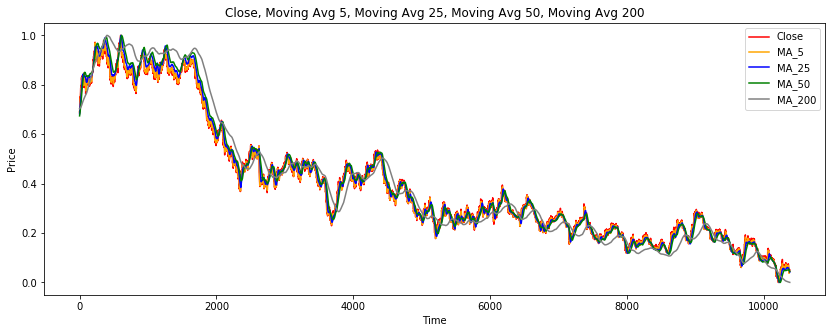

In [120]:
INICIO = 0
FIN = 10377
print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,8], color = 'orange', label = 'MA_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,9], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,10], color = 'green', label = 'MA_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,11], color = 'gray', label = 'MA_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(10377, 12)


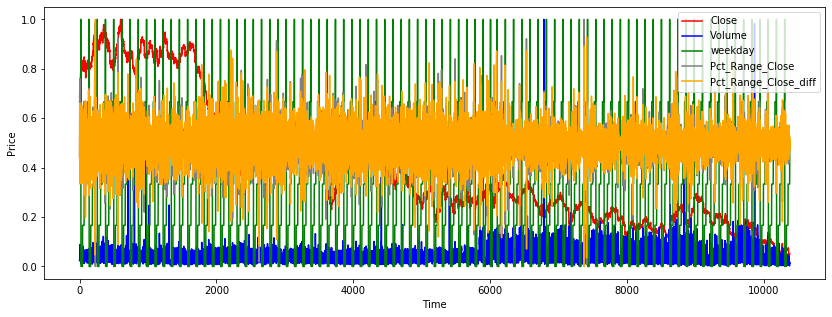

In [121]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,4], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,5], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,6], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(10377, 12)


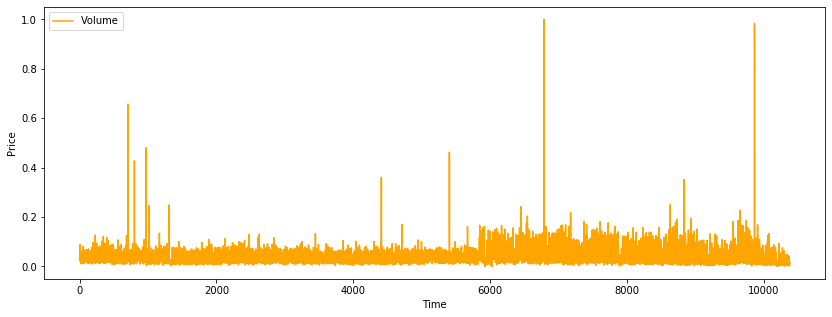

In [122]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(14,5))

pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

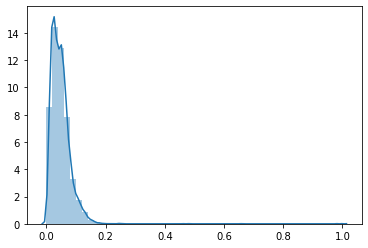

In [123]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);

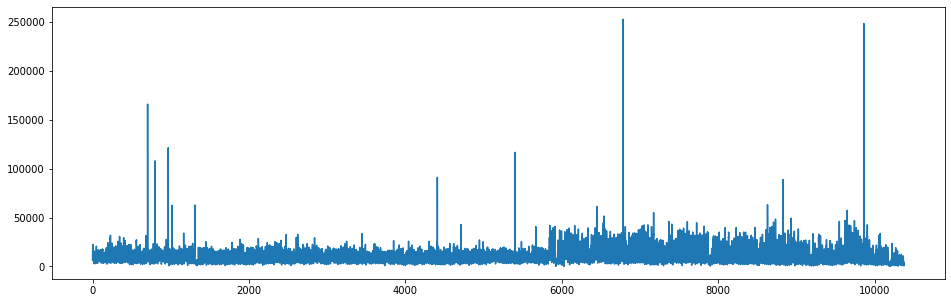

In [124]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [106]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(10374, 3, 12)
(10374,)


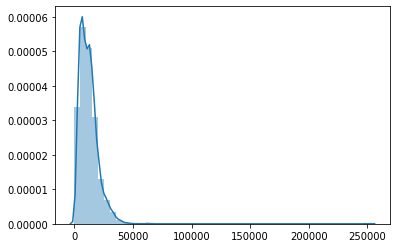

In [107]:
sns.distplot(y_train_np);



In [108]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(3, 12)
(1482, 12)
<bound method NDFrame.head of          Open     High      Low    Close     Volume  weekday  Pct_Range_Close  \
0     1.10105  1.10141  1.10088  1.10138  2668.4500        2         0.000309   
1     1.10137  1.10145  1.10082  1.10110  4444.4199        3        -0.000254   
2     1.10110  1.10155  1.10109  1.10139  3447.2100        3         0.000263   
3     1.10136  1.10137  1.10089  1.10098  2269.7400        3        -0.000372   
4     1.10100  1.10138  1.10100  1.10131  2647.1499        3         0.000300   
...       ...      ...      ...      ...        ...      ...              ...   
1480  1.10505  1.10535  1.10461  1.10517  7226.0498        4         0.000100   
1481  1.10519  1.10559  1.10497  1.10550  5337.0801        4         0.000299   
1482  1.10550  1.10567  1.10506  1.10525  4040.8999        4        -0.000226   
1483  1.10525  1.10574  1.10523  1.10561  4001.7100        4         0.000326   
1484  1.10562  1.10604  1.10541  1.10600  4070.2351        4

In [109]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(3,)
(1482,)
0     4444.4199
1     3447.2100
2     2269.7400
3     2647.1499
4     2020.2000
5     2211.0000
6     5782.3999
7    10234.3301
8     9962.1699
9     6963.5898
Name: Volume, dtype: float64


In [110]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[4.87141444e-02 4.58653132e-02 5.10664606e-02 5.08128825e-02
  1.05403014e-02 3.33333333e-01 5.15153955e-01 5.08391135e-01
  4.48816247e-02 4.41212446e-02 4.58014563e-02 8.61362930e-05]
 [5.06923838e-02 4.61128992e-02 5.06955178e-02 4.90820300e-02
  1.75691607e-02 5.00000000e-01 4.78149359e-01 4.65413363e-01
  4.49314932e-02 4.31092422e-02 4.53009084e-02 1.68389393e-04]
 [4.90232443e-02 4.67318643e-02 5.23647604e-02 5.08746986e-02
  1.36224451e-02 5.00000000e-01 5.12168354e-01 5.27029883e-01
  4.53553752e-02 4.22568941e-02 4.48622703e-02 3.18068853e-04]
 [5.06305638e-02 4.56177272e-02 5.11282844e-02 4.83402361e-02
  8.96230365e-03 5.00000000e-01 4.70391867e-01 4.61273509e-01
  4.54426450e-02 4.13066934e-02 4.44236322e-02 4.33505606e-04]
 [4.84050445e-02 4.56796237e-02 5.18083462e-02 5.03801694e-02
  1.04560007e-02 5.00000000e-01 5.14558097e-01 5.35833117e-01
  4.57792572e-02 4.04234445e-02 4.40271455e-02 5.07286283e-04]
 [5.03832839e-02 4.64223818e-02 5.31066461e-02 5.11219633e-02
  7

In [111]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(1482, 3, 12)
(1482,)


In [112]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(3, 12)
(2965, 12)


(2968, 12)

In [113]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(3,)
(2965,)


(2968,)

In [114]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[4.87141444e-02 4.58653132e-02 5.10664606e-02 5.08128825e-02
  1.05403014e-02 3.33333333e-01 5.15153955e-01 5.08391135e-01
  4.48816247e-02 4.41212446e-02 4.58014563e-02 8.61362930e-05]
 [5.06923838e-02 4.61128992e-02 5.06955178e-02 4.90820300e-02
  1.75691607e-02 5.00000000e-01 4.78149359e-01 4.65413363e-01
  4.49314932e-02 4.31092422e-02 4.53009084e-02 1.68389393e-04]
 [4.90232443e-02 4.67318643e-02 5.23647604e-02 5.08746986e-02
  1.36224451e-02 5.00000000e-01 5.12168354e-01 5.27029883e-01
  4.53553752e-02 4.22568941e-02 4.48622703e-02 3.18068853e-04]
 [7.92532146e-02 7.61327061e-02 8.08655332e-02 8.12264326e-02
  1.06046747e-02 6.66666667e-01 5.12685918e-01 4.92869700e-01
  7.38302727e-02 8.59120511e-02 8.22729620e-02 2.47864244e-02]
 [7.92532146e-02 7.43377074e-02 8.07418856e-02 7.82592570e-02
  1.63233775e-03 1.00000000e+00 4.66341800e-01 4.57310861e-01
  7.42292204e-02 8.47249439e-02 8.19910744e-02 2.49495185e-02]
 [7.81404550e-02 7.47709829e-02 8.12982998e-02 7.84447054e-02
  5

In [115]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(2965, 3, 12)
(2965,)


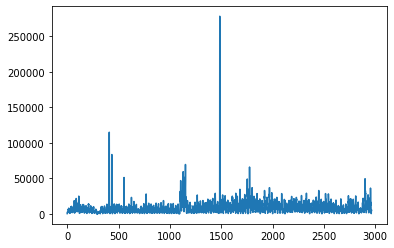

In [116]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

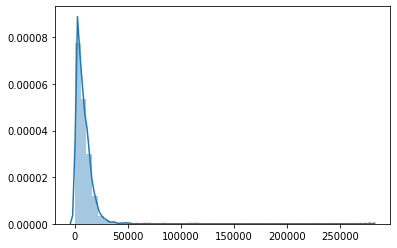

In [117]:
sns.distplot(y_test_np);


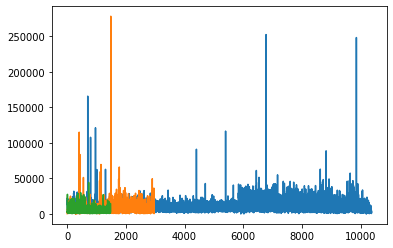

In [118]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [125]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

3
12


In [150]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 20, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 8, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


In [151]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [152]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [153]:
regressior.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3, 3)              192       
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 384       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________


In [154]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/


In [155]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [156]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





Epoch 1/10
10374/10374 [==============================] - 31s 3ms/step - loss: 90387840.0000 - mean_squared_error: 90387840.0000 - mean_absolute_error: 6507.2334 - mean_absolute_percentage_error: 100.7863 - cosine_proximity: 1.0000 - val_loss: 44816784.0000 - val_mean_squared_error: 44816784.0000 - val_mean_absolute_error: 5821.1401 - val_mean_absolute_percentage_error: 252.7154 - val_cosine_proximity: 1.00009 - mean_absolute_percentage_error: 101.0865 - co
Epoch 2/10
10374/10374 [==============================] - 27s 3ms/step - loss: 71604424.0000 - mean_squared_error: 71604424.0000 - mean_absolute_error: 5853.0396 - mean_absolute_percentage_error: 109.2155 - cosine_proximity: 1.0000 - val_loss: 46696820.0000 - val_mean_squared_error: 46696820.0000 - val_mean_absolute_error: 5969.4351 - val_mean_absolute_percentage_error: 257.0611 - val_cosine_proximity: 1.0000 - co - ETA: 10s - loss: 76372568.0000 - mean_squared_error: 76372568.0000 - mean_absolute_error: 5874.7930 - mean_absolute_pe

In [157]:
file_name = MODEL_NAME + '_' + NUM_FEATURES + '_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)
regressior.save(source_data + file_name)


LSTM_12_Volume_01.hdf5


In [158]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


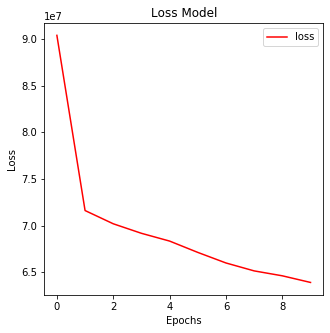

In [159]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

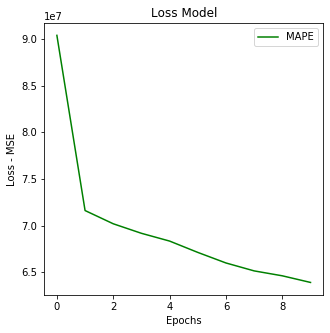

In [160]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [161]:
#Load Model
filepath = os.path.join(source_data, file_name)
#filepath = os.path.join(source_data, r'final_model.hdf5')
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/LSTM_12_Volume_01.hdf5


In [162]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(2965, 1)

In [2]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


NameError: name 'model' is not defined

(2965,)
(2965, 1)


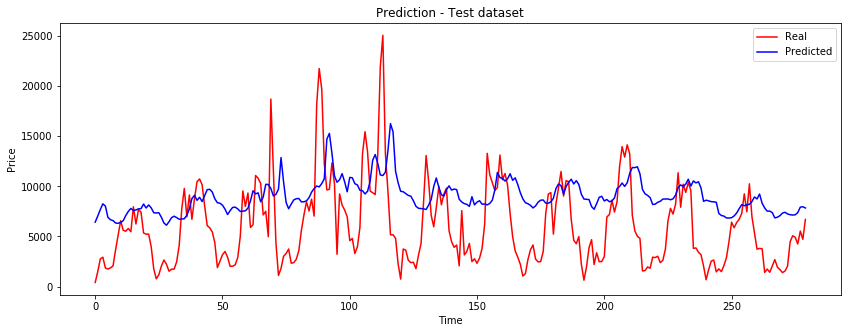

In [172]:
INICIO = 0
FIN = 280
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [165]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [166]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 6007.383630430808
Test RMSE: 9766.712588900851
Test MSE: 95388674.79419436
Test MAPE: 337.3752482278288


In [1]:
print(y_train_np.shape)
INICIO = 0
FIN = 127
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


NameError: name 'y_train_np' is not defined

In [170]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 5316.885578497061
Train RMSE: 7953.210600596726
Train MSE: 63253558.85744414
Test MAPE: 111.59671072095483
